Load train and validate datasets and concatenate them to do preprocessing on whole data

In [17]:
from __future__ import unicode_literals

import string
import numpy as np
import pandas as pd
!pip install hazm
from hazm import *
from gensim.models import Word2Vec
import codecs
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
import matplotlib.pyplot as plt
!pip install tensorflow-addons
import tensorflow_addons as tfa

t = pd.read_csv('train.csv', delimiter='\t', index_col=0)
v = pd.read_csv('dev.csv', delimiter='\t', index_col=0)
train = t[['comment', 'label_id']].copy()
validate = v[['comment', 'label_id']].copy()
frames = [train, validate]
data = pd.concat(frames, ignore_index=True)

Convert all characters to lowercase

In [18]:
data['comment'] = data['comment'].apply(lambda x: ' '.join(x.lower() for x in x.split()))

Load stop words and delete stop words from dataset

In [19]:
nmz = Normalizer()
stops = sorted(
    list(set([nmz.normalize(w) for w in codecs.open('stopwords.dat', encoding='utf-8').read().split('\n') if w]))
)

data['comment'] = data['comment'].apply(lambda x: ' '.join(x for x in x.split() if x not in stops))

Lemmatize words in dataset

In [20]:
lemmatizer = Lemmatizer()
data['comment'] = data['comment'].apply(lambda x: ' '.join([lemmatizer.lemmatize(x) for x in x.split()]))

Define an iterator to iterate through sentences and fit Word2Vector model on sentences to get word vectors and word indexes

In [21]:
class SentenceIterator:
    def __init__(self, dataset):
        self.dataset = dataset

    def __iter__(self):
        for review in self.dataset.iloc[:, 0]:
            for sentence in review.split('.')[:-1]:
                words = [w for w in sentence.split(' ') if w != '']
                yield words


sentences = SentenceIterator(data)
w2v_model = Word2Vec(sentences=sentences)
w2v_model.train(sentences, epochs=10, total_examples=len(list(sentences)))
w2v_weights = w2v_model.wv.vectors
vocab_size, embedding_size = w2v_weights.shape

Tokenize words in each sentence to make sentences into integer sequences and define an iterator to iterate through sequences

In [22]:
def word2token(word):
    try:
        return w2v_model.wv.vocab[word].index
    # If word is not in index return 0. I realize this means that this
    # is the same as the word of index 0 (i.e. most frequent word), but 0s
    # will be padded later anyway by the embedding layer (which also
    # seems dirty, but I couldn't find a better solution right now)
    except KeyError:
        return 0


MAX_SEQUENCE_LENGTH = max([len(s) for s in list(sentences)])


class SequenceIterator:
    def __init__(self, dataset, seq_length):
        self.dataset = dataset

        self.translator = str.maketrans('', '', string.punctuation + '-')
        self.sentiments, self.ccount = np.unique(dataset.label_id, return_counts=True)

        self.seq_length = seq_length

    def __iter__(self):
        for comment, label_id in zip(self.dataset.iloc[:, 0], self.dataset.iloc[:, 1]):
            words = np.array([word2token(w) for w in comment.split(' ')[:self.seq_length] if w != ''])

            yield words, label_id


sequences = SequenceIterator(data, MAX_SEQUENCE_LENGTH)

Split dataset into X and Y and also train and validate datasets

In [23]:
set_x = []
set_y = []
for w, l in sequences:
    set_x.append(w)
    set_y.append(l)

set_x = pad_sequences(set_x, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
set_y = np.array(set_y)

x = set_x[:56700]
y = set_y[:56700]
val_x = set_x[56700:]
val_y = set_y[56700:]

Define the neural network model and add the appropriate layers, compile the model and print out the details

In [24]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    weights=[w2v_weights],
                    input_length=MAX_SEQUENCE_LENGTH,
                    mask_zero=True,
                    trainable=False))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 149, 100)          367700    
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              160800    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 528,701
Trainable params: 161,001
Non-trainable params: 367,700
_________________________________________________________________
None


Fit the model on the train dataset and validate them against the validate dataset

In [25]:
history = model.fit(x, y, epochs=10, batch_size=32,
                    validation_data=(val_x, val_y), verbose=1)

Epoch 1/10
1772/1772 [==============================] - 515s 286ms/step - loss: 0.3963 - accuracy: 0.8229 - val_loss: 0.3887 - val_accuracy: 0.8273
Epoch 2/10
1772/1772 [==============================] - 504s 284ms/step - loss: 0.3730 - accuracy: 0.8348 - val_loss: 0.3816 - val_accuracy: 0.8324
Epoch 3/10
1772/1772 [==============================] - 502s 283ms/step - loss: 0.3587 - accuracy: 0.8410 - val_loss: 0.3788 - val_accuracy: 0.8289
Epoch 4/10
1772/1772 [==============================] - 503s 284ms/step - loss: 0.3417 - accuracy: 0.8491 - val_loss: 0.3781 - val_accuracy: 0.8338
Epoch 5/10
1772/1772 [==============================] - 503s 284ms/step - loss: 0.3217 - accuracy: 0.8590 - val_loss: 0.3872 - val_accuracy: 0.8325
Epoch 6/10
1772/1772 [==============================] - 507s 286ms/step - loss: 0.2969 - accuracy: 0.8710 - val_loss: 0.4041 - val_accuracy: 0.8259
Epoch 7/10
1772/1772 [==============================] - 518s 292ms/step - loss: 0.2678 - accuracy: 0.8857 - val_

Plot train and validation loss and train and validation accuracy through epochs

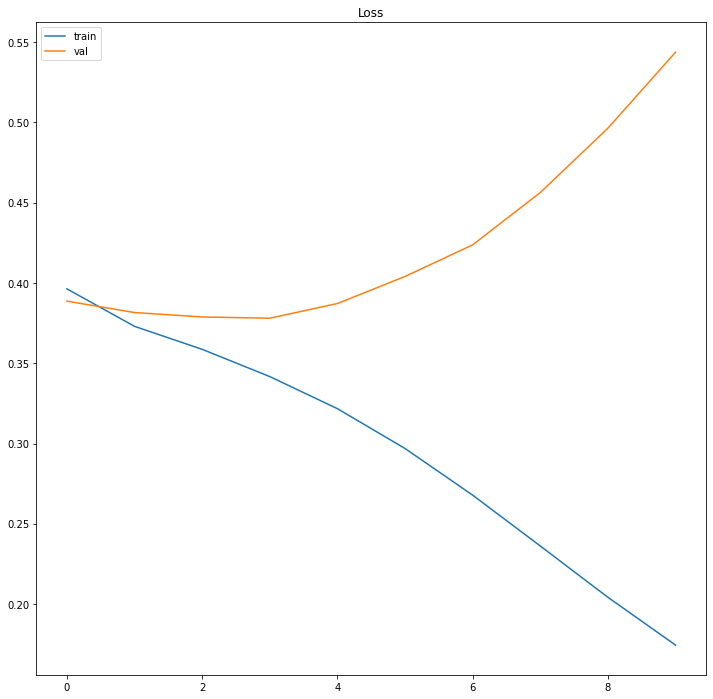

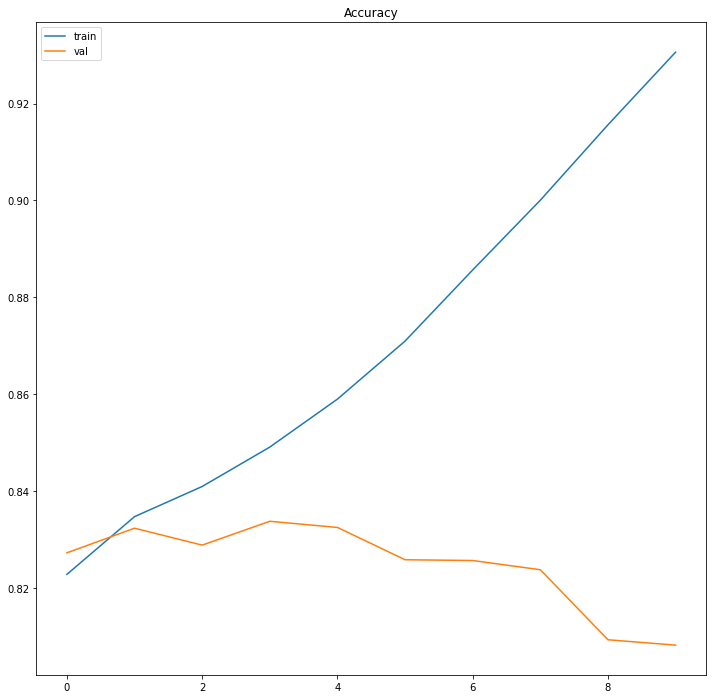

In [26]:
plt.figure(figsize=(12, 12))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(12, 12))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Predict sentiments using the model and print out the similarity between predicted sentiments and true sentiments

In [27]:
train_predictions = model.predict(x).tolist()
validate_predictions = model.predict(val_x).tolist()
train_standard = []
for i in train['label_id'].tolist():
    train_standard.append([i])
validate_standard = []
for i in validate['label_id'].tolist():
    validate_standard.append([i])

train_metric = tfa.metrics.F1Score(num_classes=1, threshold=0.5)
train_standard = np.array(train_standard[:56700], np.int64)
train_predictions = np.array(train_predictions[:56700], np.float64)
train_metric.update_state(train_standard, train_predictions)
train_result = train_metric.result()
print('F1 score of train set predictions: ' + str(train_result.numpy()))

validate_metric = tfa.metrics.F1Score(num_classes=1, threshold=0.5)
validate_standard = np.array(validate_standard[:6300], np.int64)
validate_predictions = np.array(validate_predictions[:6300], np.float64)
validate_metric.update_state(validate_standard, validate_predictions)
validate_result = validate_metric.result()
print('F1 score of validation set predictions: ' + str(validate_result.numpy()))

F1 score of train set predictions: [0.9470018]
F1 score of validation set predictions: [0.80916274]
